# Livrable 2 - Étape 2
Cette phase doit permettre de créer un Notebook en Python capable de produire les données utiles pour la simulation et l'expérimentation statistique de la solution proposée. Elle devra donc générer et stocker dans des fichiers des graphes adaptés à la situation du problème.


## Génération des données de traffic basée sur une courbe de traffic réele

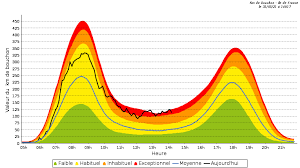

Les données de trafic seront retournée sous la forme d'un tableau de coefficient qui pourra être multiplié au poids de l'arête du graph

In [13]:
import random

# Generate traffic data for an edge
def generate():
    
    # Base weighted array
    traffic = [1, 1, 1, 1, 1, 1, 1, 2, 7, 8, 3, 2, 1, 1, 1, 2, 3, 5, 7, 5, 1, 1, 1, 1, 1]
    
    # Random weight corresponding to crash probability
    for weight in traffic:
        if(random.randrange(1,1000) < 28):
            weight += 1
    
    # Return array of slowth coeficient [1-10]
    return traffic

## Génération paramètrisé d'un graphe
Deux classe sont déclaré ici.
La classe "Edge" correspond aux arêtes. Elle possède un attribut poids qui est obtenue en multipliant une distance de base aléatoire, par une coefficient de trafic qui est variable en fonction du temps
La classe "Graph" correspond au graphe. Elle possède un attribut matrice qui correspond à la représentation matricielle du graph

In [14]:
class Edge:
    def __init__(self,length, traffic):
        # Generate an array of weight for base weight * traffic coefficient 
        self.weight = [length*i for i in traffic]

class Graph:
    def __init__(self, n, has_traffic, is_complete, is_oriented):
        g = []
        for i in range(n):
            row = []
            for j in range(n):
                    # For non oriented graphs use symmetry to generate the bottom left part of the graph
                if(j<i and not is_oriented):
                    weight = g[j][i]
                else:
                    weight = Edge(
                        # Random base weight for the edge, range start at 1 if the graphs is complete,
                        # weight is 0 if the edge is a loop
                        random.randrange((1 if is_complete else 0),10) if i!=j else 0,
                        # Generated traffic data or 1 if traffic is not used
                        generate() if has_traffic else [1] 
                        ).weight
                row.append(weight)
            g.append(row)
        self.matrice = g 


## Stockage des graphs

Cette partie consiste à appeler la génération de graphs et à les stocker dans une collection mongoDB avec les paramètre ayant servi à leur génération

In [15]:
from pymongo import MongoClient
import pprint

# Constants
GENERATE = True
STORE = False
PRINT = True

# Connection to MongoDB
client = MongoClient('localhost', 27017)
db = client['DataProject']


if(GENERATE):

    n_min = 5
    n_max = 7
    n_step = 1
    graphs_to_generate = 2
    has_traffic = False
    is_complete = False
    is_oriented = False

    for n in range(n_min, n_max, n_step) :
        data = []
        for _ in range(graphs_to_generate):
            
            # Generate a graph with parameters
            matrice = Graph(n, has_traffic, is_complete, is_oriented).matrice
            if(PRINT): 
                # Print graph using pprint
                pprint.pprint(matrice) 

            # Generate the row that will be saved in MongoDB       
            data.append({"n" : n, "has_traffic" : has_traffic, "is_complete" : is_complete, "is_oriented" : is_oriented, "matrice" : matrice})
        if(STORE):
            # Save generated data into graphs collection
            graphs = db['graphs']
            graphs.insert_many(list(data))


ModuleNotFoundError: No module named 'pymongo'

# Etape 3 : Modélisation du problème
Cette phase aboutira à la création d'un notebook décrivant :

- La définition du problème formel

- L'étude de complexité de ce problème

Il est fortement recommandé d'intégrer à ce notebook des références bibliographiques vers des articles ou des ouvrages scientifiques.


## Définition du problème formel
<p>n = le nombre de ville </p>
v = le nombre de véhicule

<p>x{i,j} => voyage d'une ville i à une ville j<br>
x{i,i} = 1 => le véhicule voyage de la ville i à la ville j<br>
       = 0 => le véhicule ne voyage pas</p>

x{i,i} = 0 => il n'y a pas de voyage dans la même ville

a{i,j} = la distance entre la ville i et la ville j


#### Si on ne passe qu'une fois par ville
Cela signifie qu'une ville ne peut être l'arrivé d'un voyage (j) qu'une seule fois. Donc : <br>
                x{1,j} + x{2,j} + x{3,j} + x{4,j} = 1

De la même manière, une ville ne peut être un point de départ (i) qu'une seule fois. Donc : <br>
                x{i,1} + x{i,2} + x{i,3} + x{i,4} = 1

Pour éviter les mini cycles x{i,j} = x{j,i} = 1 on utilise la contrainte : <br>
                x{i,j} + x{j,i} ≤ 1


### Définition du problème
Les contraintes décritent, on ajoute les distances pour obtenir la solution à notre problème :

\begin{equation}
 \sum_{i=1}^n  \sum_{j=1}^n x_{i,j}a_{i,j}
\end{equation}


Notre modèle mathématique consiste à minimiser cette fonction, dite fonction objectif par rapport aux variables x{i,j} , tout en satisfaisant les contraintes préalablement décrites:

\begin{equation}
     \sum_{i=1}^n  \sum_{j=1}^n x_{i,j}a_{i,j} \\
 s.c.  x_{i,i} = 0 , \forall i\in [1;n]  \\
 \sum_{i=1}^n x_{i,j} = 1, \forall j\in [1;n]  \\
 \sum_{j=1}^n x_{i,j} = 1, \forall i\in [1;n]  \\
 x_{i,j} + x{j,i} = 1, i = 1,...,n\ et\ j = 1,...,n \\
 x_{i,j} \in{0;1}, i = 1,...,n\ et\ j = 1,...,n \\
\end{equation}

s.c = "sous les contraintes"


## Etude de complexité de ce problème

Notre problème est similaire à un problème du voyageur du commerce possédant une contrainte supplémentaire étant une fenêtre temporelle de livraison, on peut donc penser qu'il serait donc NP-complet.
Nous allons donc voir si c'est effectivement le cas :

D'abords, nous pouvons verifier la solution dans un temps polynomiale en vérifiant que on passe par tous les sommets du graph et qu'on remplisse les conditions associées aux sommets et leurs horaires. Notre problème est donc dans NP.

Ensuite nous allons faire une réduction à partire du problème du Cycle Hamiltonien. Soit I ≤ G = (V, E) > une instance du problème du cycle Hamiltonien. A présent nous allons transformer cette instance en une instance I' de notre problème de la façon suivante: 

Soit le graph G'=(V', E') tel que 
$$
    V' = V, donc\ soit\ u\ et\ u'\ et\ v\ et\ v'\ des\ sommets\ arbitraires\ voisins\ de\ V\ et\ V' \\

    Soit\ H_u\ la\ plage\ horaire\ associée\ a\ la\ livraison\ au\ lieu\ représenté\ par\ le\ sommet\ u \\

    Soit\ P_uv\ le\ poids\ de\ l'\ arrête\ entre\ u\ et\ v\,\ il\ est\ égale\ au\ tepps\ de\ trajet\ dans\ le\ graph\ G\,\\ 
    contrairement\ à\ sa\ version\ de\ G':\ P'_{uv_t} = |uv| + p_t,\ p_t\ étant\ le\ temps\ supplémentaire\ ajouté\ théorique\ en\ fonction\ du\ temps\ et\ d'\ une\ fonction\ aléatoire\ représentative\ des\ accidents.\\
 
$$

Cette transformation peut se faire en temps polynomiale (le graph est le même à la différence des poids de arrête)

Si il existe une solution dans G', alors il existe un cycle Hamiltonien dans G tel que :

Soit C' = (u', l1....ln-1, u') une solution de notre problème. Le cycle C = (u, l1....ln-1, u) existe dans le graph G. Ce cycle est Hamiltonien car il passe une et une seule par tous les sommets du graph car C' est un cycle Hamiltonien.


Si il existe un cycle Hamiltonien dans G respectant les contraintes ci-dessus, alors il existe une solution dans G' :

Soit  C = (u, l1....ln-1, u) un cycle Hamiltonien respectant les contraintes ci-dessus. Le cycle C' = (u', l1....ln-1, u') existe dans le graph G'. Ce cyle, en plus d'être Hamiltonien repecte les contraintes supplémentaire, c'est donc une solution de notre problème.

Donc Cycle Hamiltonien ≤ Notre problème
Donc notre problème est NP-complet.






